In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

# Generate data:
# $x_i=c+A[0]x_{i-1}+...+A[n-1]x_{i-n}+\epsilon_{i}+B[0]\epsilon_{i-1}+...+B[m-1]\epsilon_{i-m}$, where $\epsilon_j\sim \mathcal{N}(0,\sigma^2)$

In [21]:
def get_data(c,A,B,N,sigma):
    eps = np.random.normal(0,sigma,N)
    X   = []
    for i in range(N):
        xi = c
        for k in range(len(A)): 
            if k<i: xi = xi + A[k]*X[-k-1]
        xi = xi + eps[i]
        for k in range(len(B)): 
            if k<i: xi = xi + B[k]*eps[i-k-1]
        X.append(xi)
    return np.array(X)

In [22]:
N = int(1e4)
#N_test = int(N*.1)
N_test = 100
X = get_data(0, [1/2, 5/18, -1/9],[-1/2, 4/9, -2/9], N=N,sigma=1)

# Visualize the data

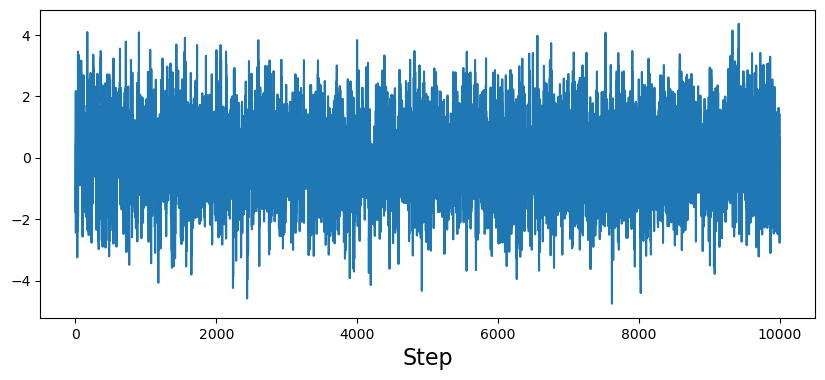

In [24]:
plt.figure(figsize=(10,4))
plt.plot(X,'-')
plt.xlabel('Step', fontsize=16)
plt.show()

# ACF and PACF

In [25]:
X_train, X_test = X[:-N_test],X[-N_test:]

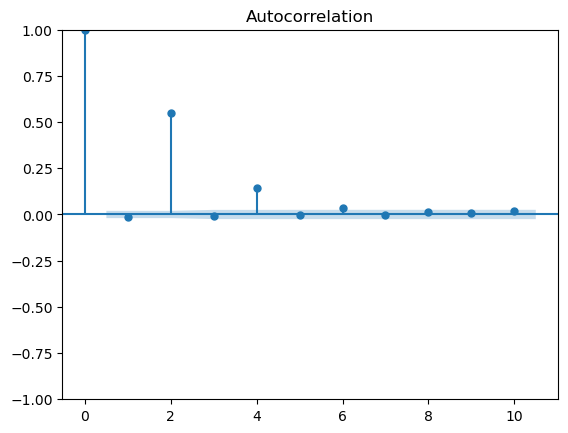

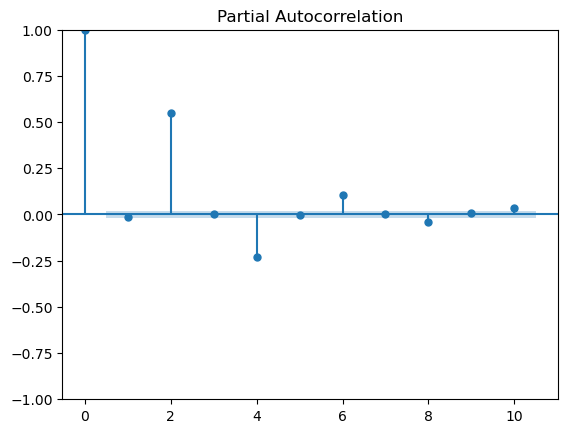

In [26]:
num_lags = 10

plot_acf(X_train,lags=num_lags)
plt.show()
plot_pacf(X_train,lags=num_lags)
plt.show()

# fit the model

In [28]:
#fit the model
model = ARIMA(X_train, order=(4,0,4))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9900
Model:                 ARIMA(4, 0, 4)   Log Likelihood              -13983.884
Date:                Sat, 08 Jul 2023   AIC                          27987.768
Time:                        16:32:17   BIC                          28059.771
Sample:                             0   HQIC                         28012.153
                               - 9900                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0180      0.019      0.927      0.354      -0.020       0.056
ar.L1         -0.3175      4.021     -0.079      0.937      -8.198       7.563
ar.L2          0.5176      4.041      0.128      0.8

# Prediction

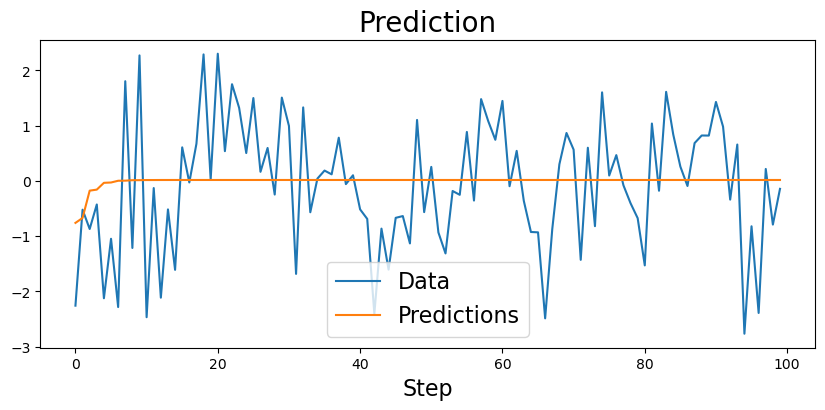

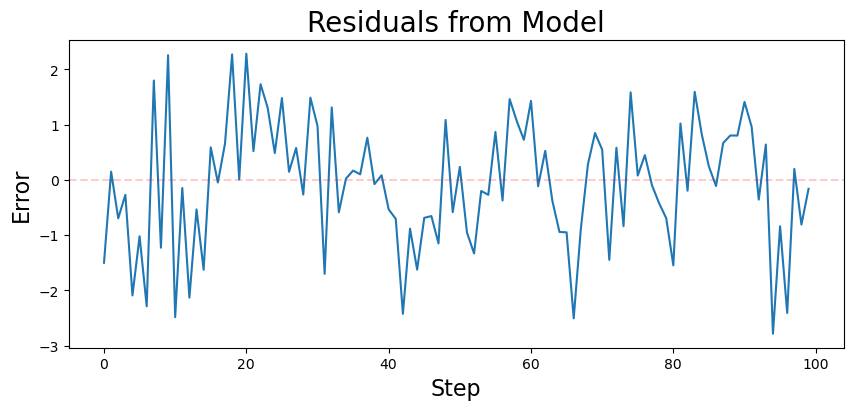

Root Mean Squared Error of Residuals: 1.1486580460776727


In [29]:
# number of predictions
N_pred = N_test

predictions = model_fit.forecast(steps=N_pred)
    
plt.figure(figsize=(10,4))
plt.plot(X_test[:N_pred])
plt.plot(predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('Prediction', fontsize=20)
plt.xlabel('Step', fontsize=16)
plt.show()

residuals = X_test[:N_pred] - predictions
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from Model', fontsize=20)
plt.xlabel('Step', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
plt.show()

print('Root Mean Squared Error of Residuals:', np.sqrt(np.mean(residuals**2)))

# Rolling Forecast Origin

In [30]:
rolling_predictions = []
t0 = time()
for i in range(N_test):
    if i%10==0: print("step: %d, total cost time: %.1f" %(i,time()-t0))
    train = X[:-(N_test-i)]
    model = ARIMA(train, order=(2,0,1))
    model_fit = model.fit()
    pred = model_fit.forecast(steps=1)
    rolling_predictions.append(pred[0])

step: 0, total cost time: 0.0
step: 10, total cost time: 5.2
step: 20, total cost time: 9.9
step: 30, total cost time: 14.7
step: 40, total cost time: 19.6
step: 50, total cost time: 24.6
step: 60, total cost time: 29.5
step: 70, total cost time: 34.5
step: 80, total cost time: 39.0
step: 90, total cost time: 43.9


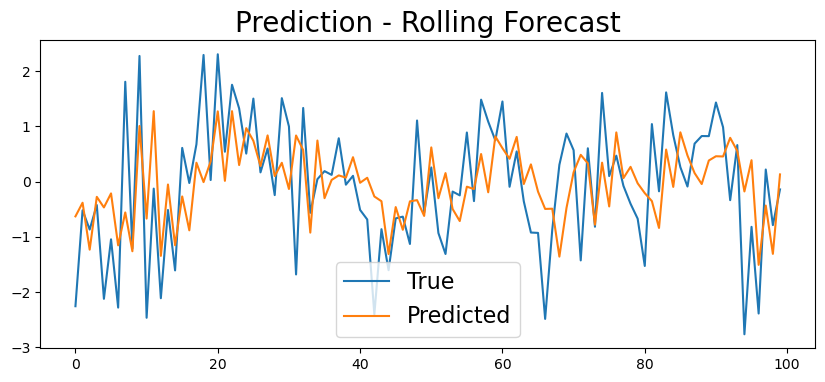

In [31]:
plt.figure(figsize=(10,4))
true, = plt.plot(X[-N_test:])
preds, = plt.plot(rolling_predictions)
plt.title('Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True', 'Predicted'], fontsize=16)